<a href="https://colab.research.google.com/github/faranbutt/Machine-Learing-MIPT/blob/main/Copy_of_Boosting_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install xgboost
!pip install lightgbm
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.3 MB/s eta 0:00:00


# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Lab assignment №2
## Gradient boosting and model analysis

Today we will work with Gradient Boosting library. It is one of the most popular models these days that shows both great quality and performance.

Choises for library are:

* [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. Handful and fast.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

**Dataset**

By default we will work with widely known [Human Actividy Recognition (HAR) dataset](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones). Data is available at UCI repository.

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.
Some simple preprocessing is done for you.

If you want more interpretable data, you can take [Wine quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) (see details below).

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian if it's more convenient for you._

In [6]:
# Download and unpack dataset from UCI
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -q -u "UCI HAR Dataset.zip"

--2025-05-14 18:09:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip     [    <=>             ]  58.17M  94.2MB/s    in 0.6s    

2025-05-14 18:09:31 (94.2 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314]



In [4]:
from pathlib import Path
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,label_binarize
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve,auc, classification_report,accuracy_score,confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
import optuna

In [7]:
def read_har_labels(path: Path) -> dict[int, str]:
    labels = {}
    with path.open() as file:
        for line in file:
            label, name = line.strip().split(" ")
            labels[int(label)] = name

    return labels


def read_har(path: Union[str, Path]) -> tuple:
    path = Path(path)

    activity_labels = read_har_labels(path / "activity_labels.txt")
    feature_labels = read_har_labels(path / "features.txt")

    X_train = np.genfromtxt(path / "train/X_train.txt")
    y_train = np.genfromtxt(path / "train/y_train.txt")
    X_test = np.genfromtxt(path / "test/X_test.txt")
    y_test = np.genfromtxt(path / "test/y_test.txt")

    return activity_labels, feature_labels, X_train, y_train, X_test, y_test

In [8]:
activity_labels, feature_labels, X_train, y_train, X_test, y_test = read_har("UCI HAR Dataset")
n_features = X_train.shape[1]

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")
print("Activity labels: ", activity_labels)

Train set: (7352, 561), (7352,)
Test set: (2947, 561), (2947,)
Activity labels:  {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


### Alternative dataset: Wine quality

Please, take this dataset if you are sure you can preprocess it yourself and ready to work with it's features and results.

However you will have more interpretable features which can be analysed with shap in last part.

In [ ]:
!pip install ucimlrepo

In [ ]:
import ucimlrepo as uci

In [ ]:
dataset = uci.fetch_ucirepo(id=186)

print(dataset.metadata.name, '\n')
print(dataset.metadata.abstract, '\n')
print(dataset.metadata.additional_info.summary, '\n')

Wine Quality 

Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/). 

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].  Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks.  The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to t

### Analyse and preprocess data

First you need to analyse data you have (including performing EDA in a section below).

Get insights on the data you have by calculating basic statistics, plotting data and so on.

_Tip: data may contain some nasty artefacts. So, don't hesitate to deal with them._

In [9]:
import pandas as pd

In [10]:
# YOUR CODE HERE
pd.DataFrame(X_train,columns = feature_labels)

,1,2,3,4,5,6,7,8,9,10,...,552,553,554,555,556,557,558,559,560,561
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.070157,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,0.165259,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,0.195034,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,0.013865,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339


In [11]:
features = [feature_labels[i+1] for i in range(n_features)]
df_train = pd.DataFrame(X_train,columns = features)
df_test = pd.DataFrame(X_test,columns = features)
df_train["Activity"] = y_train
df_test["Activity"] = y_test

In [12]:
df_full = pd.concat((df_train,df_test),axis=0)
df_full["Activity"] = df_full["Activity"].map(dict(activity_labels))
df_full.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,STANDING


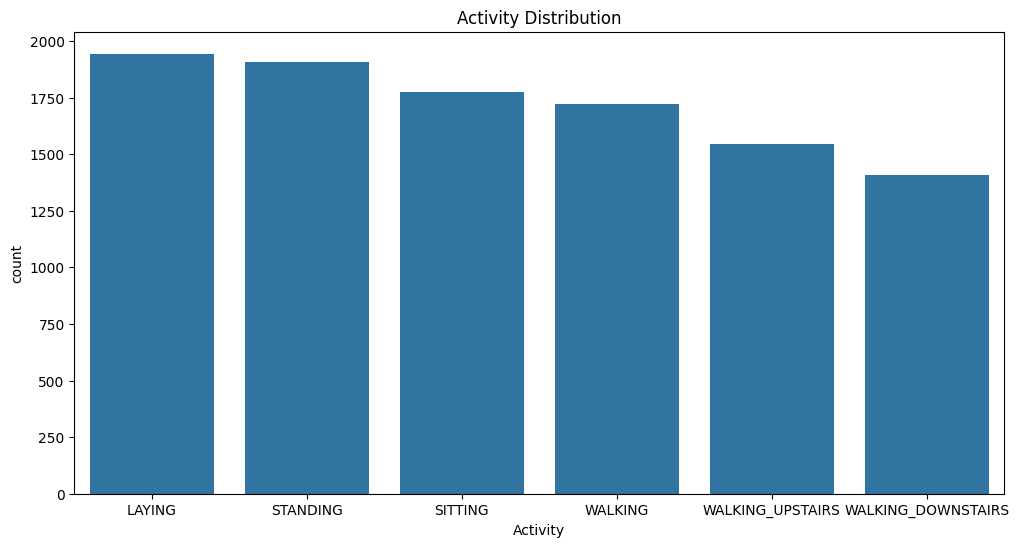

In [13]:
plt.figure(figsize=(12,6))
sns.countplot(data=df_full,x = "Activity",order=df_full['Activity'].value_counts().index)
plt.title("Activity Distribution")
plt.show()

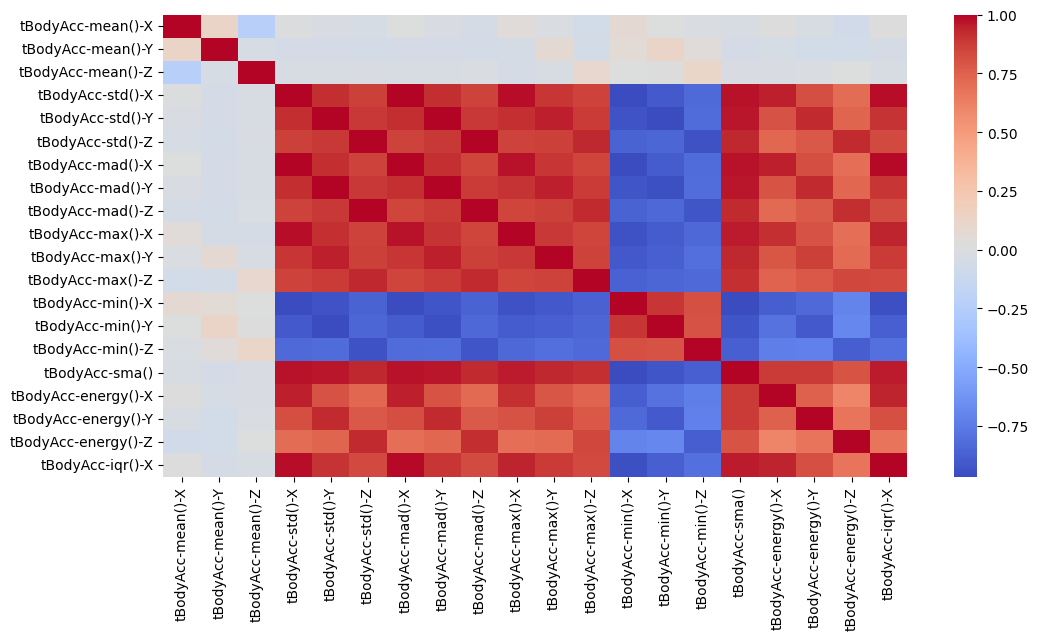

In [14]:
plt.figure(figsize=(12,6))
sns.heatmap(df_full.iloc[:,:20].corr(),cmap='coolwarm',annot=False)
plt.show()

In [15]:
df_full.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,...,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000
mean,0.274347,-0.017743,-0.108925,-0.607784,-0.510191,-0.613064,-0.633593,-0.525697,-0.614989,-0.466732,...,0.126708,-0.298592,-0.617700,0.007705,0.002648,0.017683,-0.009219,-0.496522,0.063255,-0.054284
std,0.067628,0.037128,0.053033,0.438694,0.500240,0.403657,0.413333,0.484201,0.399034,0.538707,...,0.245443,0.320199,0.308796,0.336591,0.447364,0.616188,0.484770,0.511158,0.305468,0.268898
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262625,-0.024902,-0.121019,-0.992360,-0.976990,-0.979137,-0.993293,-0.977017,-0.979064,-0.935788,...,-0.019481,-0.536174,-0.841847,-0.124694,-0.287031,-0.493108,-0.389041,-0.817288,0.002151,-0.131880
50%,0.277174,-0.017162,-0.108596,-0.943030,-0.835032,-0.850773,-0.948244,-0.843670,-0.845068,-0.874825,...,0.136245,-0.335160,-0.703402,0.008146,0.007668,0.017192,-0.007186,-0.715631,0.182028,-0.003882
75%,0.288354,-0.010625,-0.097589,-0.250293,-0.057336,-0.278737,-0.302033,-0.087405,-0.288149,-0.014641,...,0.288960,-0.113167,-0.487981,0.149005,0.291490,0.536137,0.365996,-0.521503,0.250790,0.102970
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


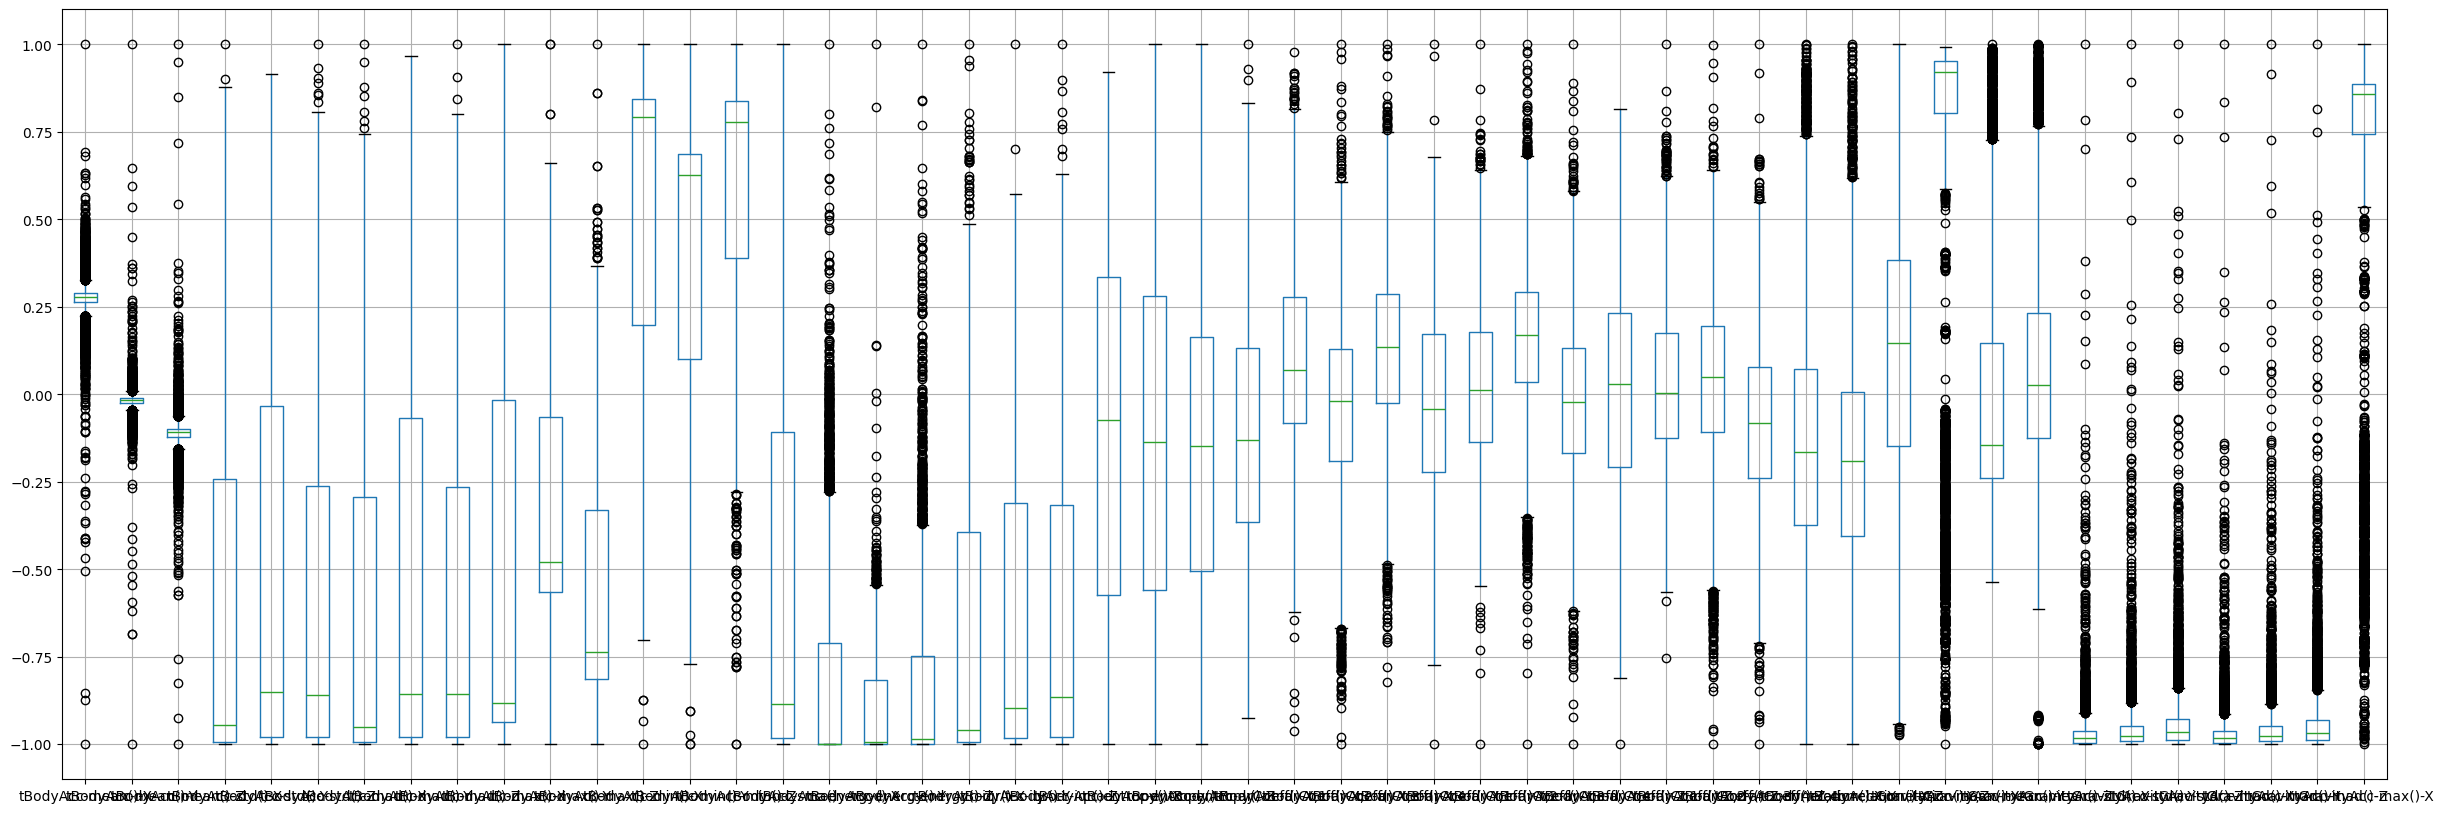

In [16]:
plt.figure(figsize=(30,10))
df_train.iloc[:,:50].boxplot()
plt.show()

Apply PCA to the data

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# YOUR CODE HERE
preprocess = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.99))
])

In [ ]:
X_train_pca = preprocess.fit_transform(X_train)
X_test_pca = preprocess.transform(X_test)

In [ ]:
X_train_pca.shape,X_test_pca.shape

((7352, 155), (2947, 155))

Text(0, 0.5, 'Principal component 2')

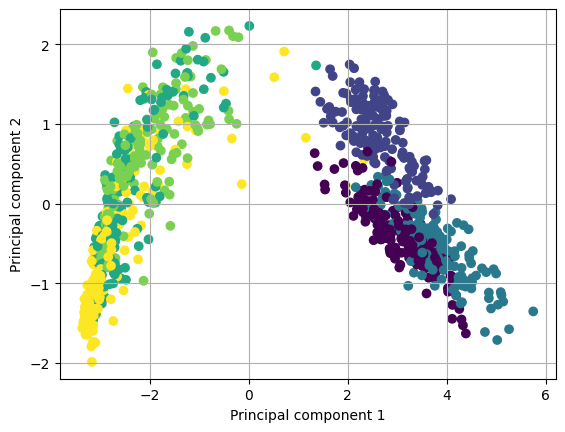

In [ ]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

Text(0, 0.5, 'Principal component 5')

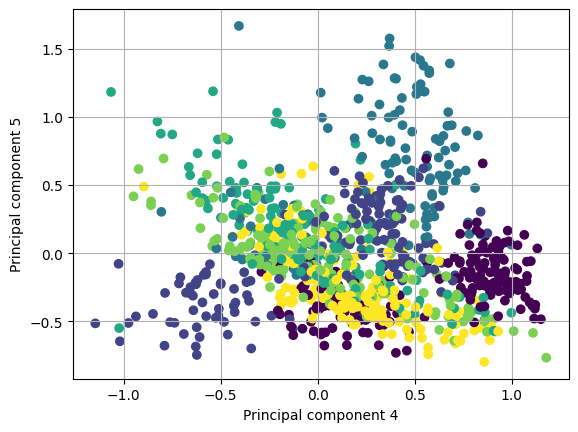

In [ ]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 4")
plt.ylabel("Principal component 5")

## Part 1: Fit the model

Rough example for that part: https://rpubs.com/burakh/har_xgb

Write basic model building and validation procedure. At this point you don't need to pick hyperparameters intensively. You may check a few by hand if you want. Use original feature set.

In [ ]:
# YOUR CODE HERE
lgbm = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='multiclass',
    num_class=6,
    random_state=42
)

In [ ]:
lgbm.fit(X_train_pca, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39525
[LightGBM] [Info] Number of data points in the train set: 7352, number of used features: 155
[LightGBM] [Info] Start training from score -1.791216
[LightGBM] [Info] Start training from score -1.924514
[LightGBM] [Info] Start training from score -2.009071
[LightGBM] [Info] Start training from score -1.743436
[LightGBM] [Info] Start training from score -1.677246
[LightGBM] [Info] Start training from score -1.653513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

LGBMClassifier(max_depth=6, num_class=6, objective='multiclass',
               random_state=42)

In [ ]:
y_pred = lgbm.predict(X_test_pca)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Metrics and plots

Calculate metrics for classification problem which we discussed on lecture.

Plot visualizations needed.

In [ ]:
accuracy_score(y_test,y_pred)

0.9321343739395996

In [ ]:
print(classification_report(y_test,y_pred,target_names = activity_labels.values()))

                    precision    recall  f1-score   support

           WALKING       0.92      0.97      0.95       496
  WALKING_UPSTAIRS       0.93      0.93      0.93       471
WALKING_DOWNSTAIRS       0.95      0.89      0.92       420
           SITTING       0.90      0.89      0.90       491
          STANDING       0.90      0.94      0.92       532
            LAYING       0.99      0.95      0.97       537

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947



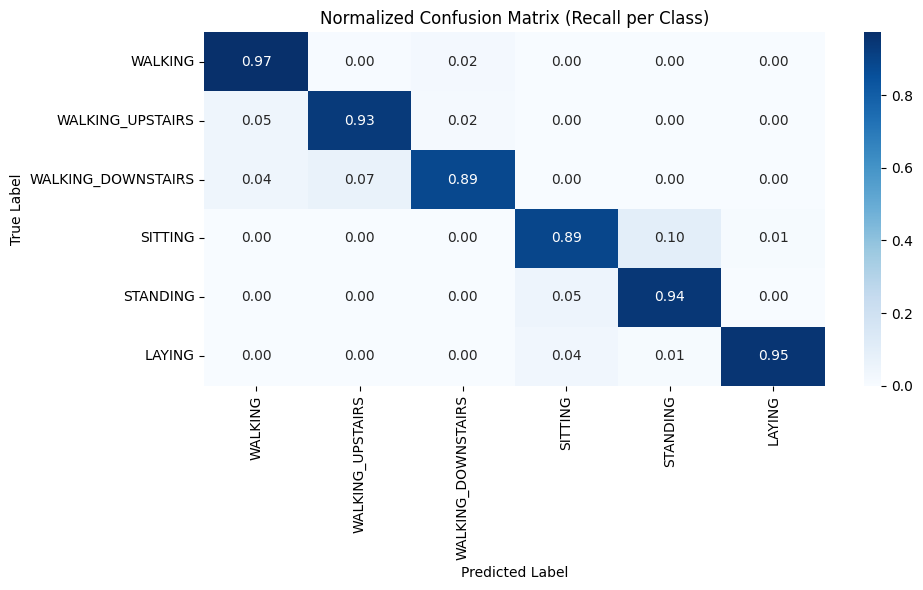

In [ ]:
cm = confusion_matrix(y_test, y_pred, normalize="true")

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=list(activity_labels.values()),
            yticklabels=list(activity_labels.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Recall per Class)')
plt.tight_layout()
plt.show()

In [ ]:
y_test_bin = label_binarize(y_test,classes = np.unique(y_test))
y_score = lgbm.predict_proba(X_test_pca)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test_bin.shape[1]):
  fpr[i],tpr[i],_ = roc_curve(y_test_bin[:,i],y_score[:,i])
  roc_auc[i] = auc(fpr[i],tpr[i])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


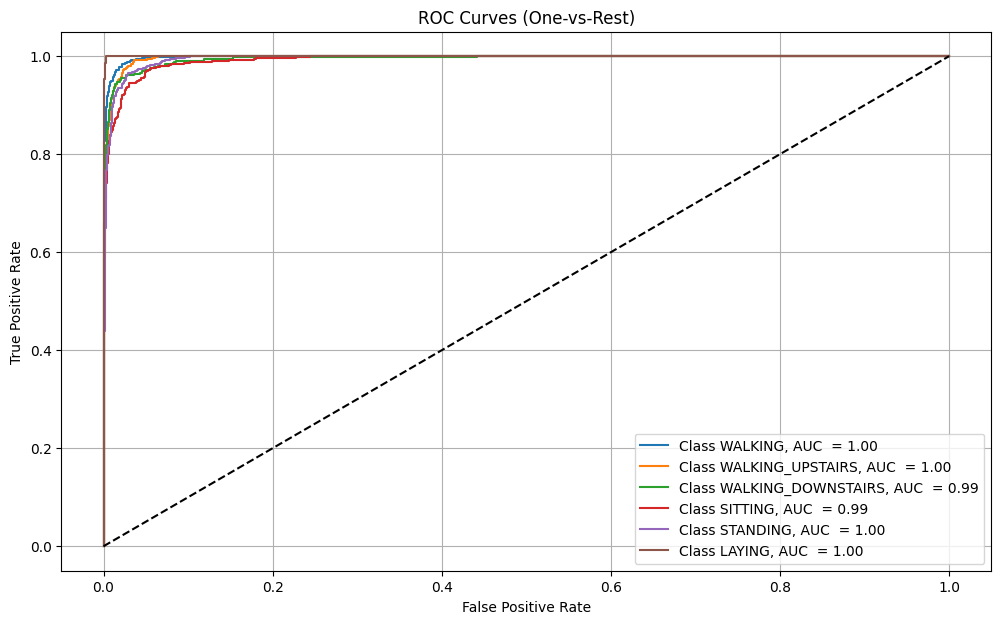

In [ ]:
plt.figure(figsize=(12,7))
for i in range(y_test_bin.shape[1]):
  plt.plot(fpr[i], tpr[i], label=f"Class {activity_labels[i+1]}, AUC  = {roc_auc[i]:.2f}")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.show()


### Conclusion on basic model results

Describe what do you see in data you acquired, what can you say about that model?

LightGBM 93.2% accuracy showed that LightGBM achieves excellent results on MinMaxScaled HAR data even without hyperparameter tuning. This suggests the features are inherently well-suited for gradient boosing.

LightGBM's leaf wise growth strategy can lead to overfitting particularly when trees grow too deep

SO precautionary measures can be
1. limiting the leafs to 50
2. Increasing n_estimators to ensure sufficient model capacity
3. Added L2 regularization (reg_lambda=0.1)

The ROC curves show near-perfect classification for all activities AUC is 1 for most classees so this indicates excellent discriminative power

Used MinMaxscaler because of the non normal distribution in box plot with outliers and skewed values

PCA also preserved 99% varinace improving the computation efficiency

## Part 2: Use hyper parameter tuning system

Use [optuna](https://optuna.org/) or [hyperopt](http://hyperopt.github.io/hyperopt/) zero order optimizer to find optimal hyper param set.

In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': 6,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 450, 500),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 0.8),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 0.8),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.6),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 0.6),
        'random_state': 42,
        'verbosity': -1
    }

    pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.99)),
    ('clf', LGBMClassifier(**params))
    ])
    score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy').mean()
    return score

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-13 16:48:59,077] A new study created in memory with name: no-name-0c5144b1-f952-4925-b341-d3603ed66411
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials: 100
Best trial:
  Value: 0.9823164398322211
  Params: 
    n_estimators: 476
    num_leaves: 35
    max_depth: 10
    learning_rate: 0.09275467401168462
    min_child_samples: 36
    feature_fraction: 0.7419844054284936
    bagging_fraction: 0.4972713623602371
    bagging_freq: 7
    reg_alpha: 0.014341371646718098
    reg_lambda: 0.31266164024687054


### Conclusion

Please, write down your thoughts on the experiment results (which hparams are more important than others, which improve did you get, etc):

**Tuning improved accuracy by 2%, with feature fractions and tree depth being most impactful. The model now generalizes better to unseen data**

More trees greater than 400 improved robustness.

num_leaves=35 and max_depth=10 shows deeper trees captured complex patterns

learning_rate=0.093 => balanced speed and performance

Bagging -> bagging_fraction=0.5, bagging_freq=7 -> reduced overfitting




## Part 3. Interpret the model predictions

Train model with the best hparams you've found and analyze it.

Please use [shap](https://github.com/slundberg/shap) to build beeswarm plot and at least one more of your choice and interpret them (in a conclusion section below).

Feature names were presented in dataset loading function.|

In [ ]:
import shap  # noqa: F401
best_params = study.best_params
best_params.update({
    'objective': 'multiclass',
    'num_class': 6,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'random_state': 42,
    'verbosity': -1
})

In [ ]:
lgbm = Pipeline([
    ("minmax", MinMaxScaler()),
    ("pca", PCA(0.99)),
     ("lgbm", LGBMClassifier(**best_params))
])

In [ ]:
lgbm.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

Pipeline(steps=[('minmax', MinMaxScaler()), ('pca', PCA(n_components=0.99)),
                ('lgbm',
                 LGBMClassifier(bagging_fraction=0.4972713623602371,
                                bagging_freq=7,
                                feature_fraction=0.7419844054284936,
                                learning_rate=0.09275467401168462, max_depth=10,
                                min_child_samples=36, n_estimators=476,
                                num_leaves=35, reg_alpha=0.014341371646718098,
                                reg_lambda=0.31266164024687054))])

In [ ]:
y_pred = lgbm.predict(X_test)
accuracy_score(y_test,y_pred)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


0.9528333898880217

In [ ]:
print(classification_report(y_test,y_pred,target_names = activity_labels.values()))

                    precision    recall  f1-score   support

           WALKING       0.93      0.99      0.96       496
  WALKING_UPSTAIRS       0.96      0.95      0.96       471
WALKING_DOWNSTAIRS       0.98      0.91      0.95       420
           SITTING       0.95      0.90      0.93       491
          STANDING       0.91      0.95      0.93       532
            LAYING       0.99      0.99      0.99       537

          accuracy                           0.95      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947



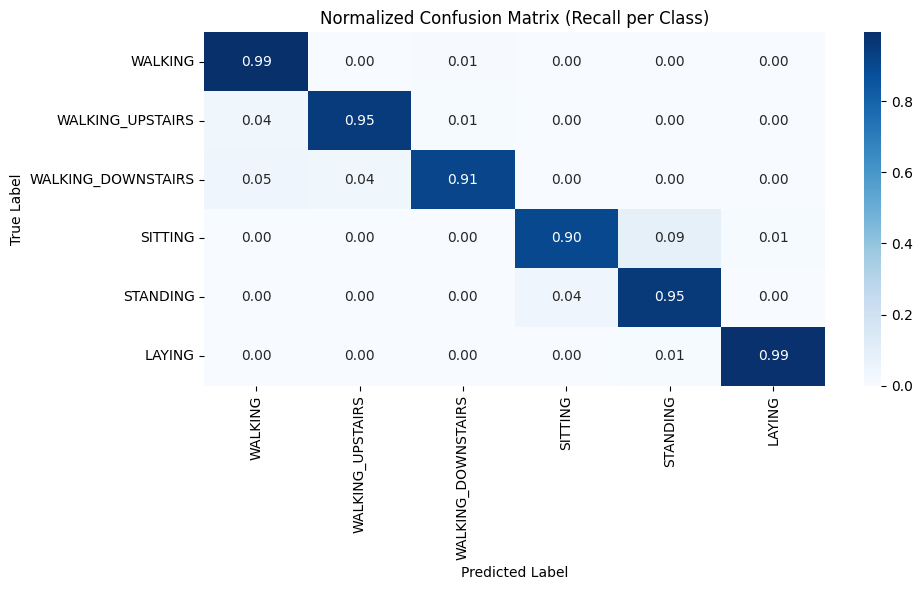

In [ ]:
cm = confusion_matrix(y_test, y_pred, normalize="true")

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=list(activity_labels.values()),
            yticklabels=list(activity_labels.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Recall per Class)')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


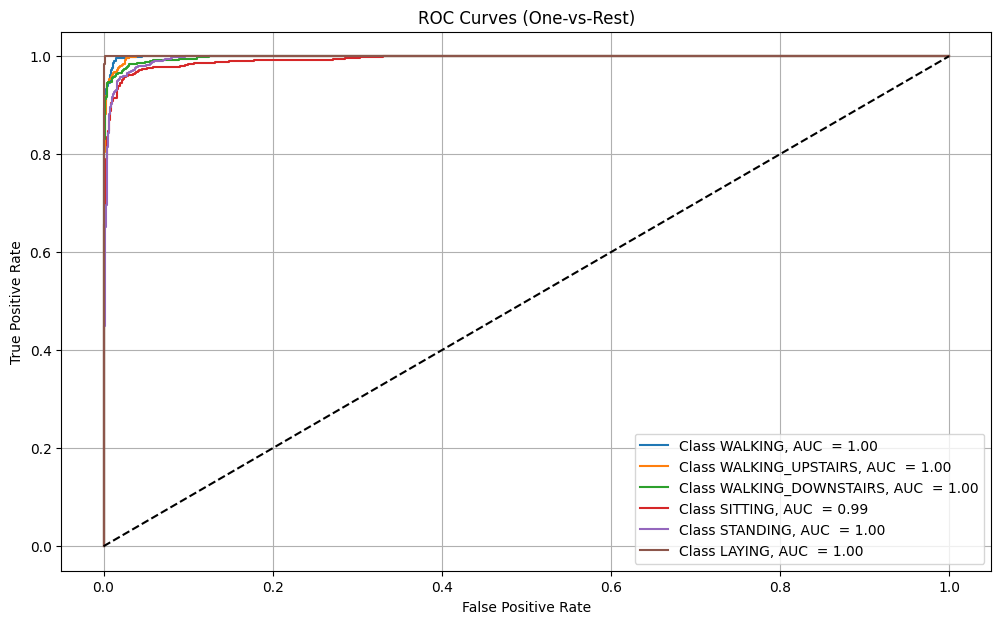

In [ ]:
y_test_bin = label_binarize(y_test,classes = np.unique(y_test))
y_score = lgbm.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test_bin.shape[1]):
  fpr[i],tpr[i],_ = roc_curve(y_test_bin[:,i],y_score[:,i])
  roc_auc[i] = auc(fpr[i],tpr[i])
plt.figure(figsize=(12,7))
for i in range(y_test_bin.shape[1]):
  plt.plot(fpr[i], tpr[i], label=f"Class {activity_labels[i+1]}, AUC  = {roc_auc[i]:.2f}")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
shap.initjs()

In [ ]:
explainer = shap.KernelExplainer(lgbm.predict_proba, shap.sample(X_train, 80))
X_test_sample = shap.sample(X_test, 50)
shap_values = explainer.shap_values(X_test_sample, l1_reg="aic")

[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7419844054284936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419844054284936
[LightGBM] [Warning] bagging_fraction is set=0.4972713623602371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4972713623602371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [ ]:
print("X_test shape:", X_test.shape)
print("shap_values shape:", np.array(shap_values).shape)

X_test shape: (2947, 561)
shap_values shape: (50, 561, 6)


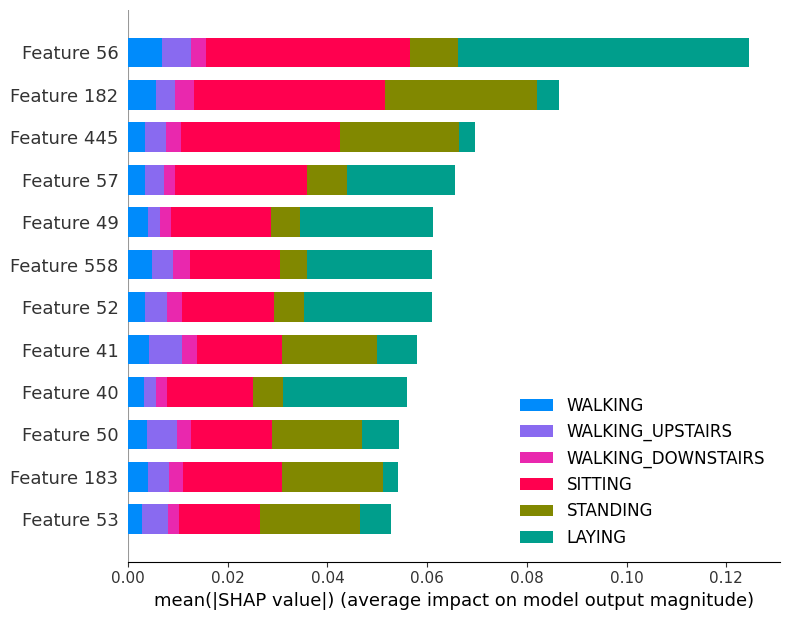

In [ ]:
shap.summary_plot(
    shap_values,
    X_test[:50],
    plot_type='bar',
    max_display=12,
    class_inds=[0, 1, 2, 3, 4, 5],
    class_names=[activity_labels[i] for i in range(1, 7)]
)

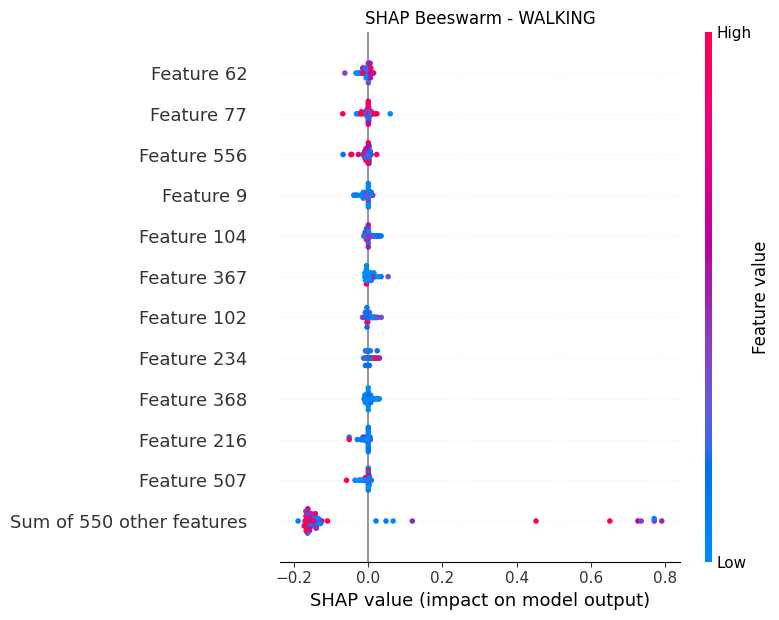

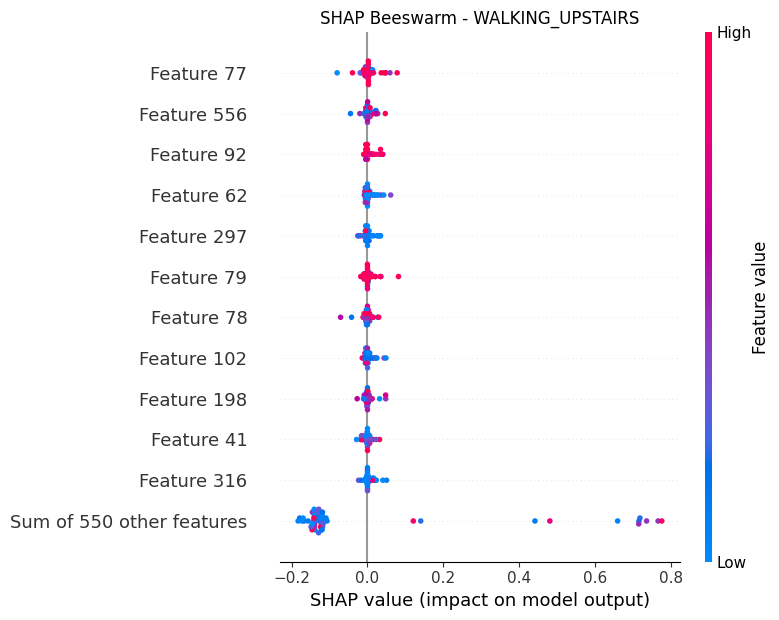

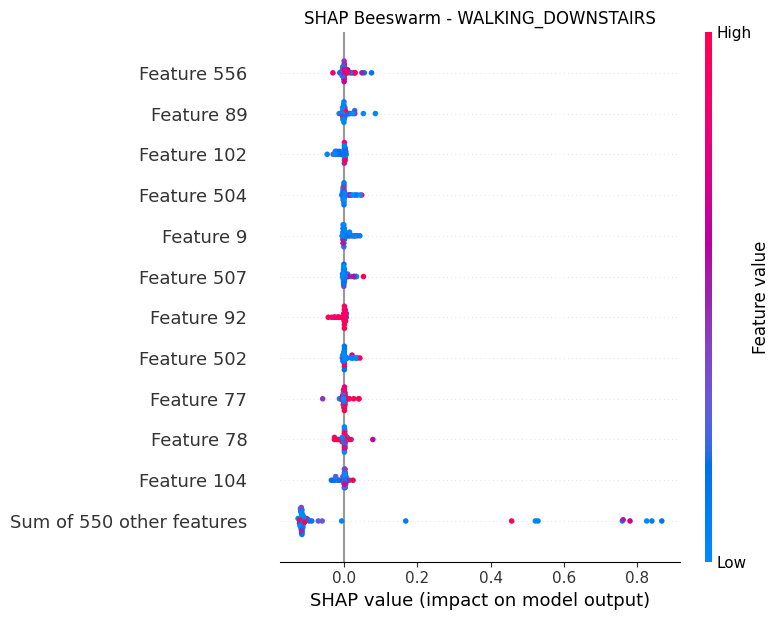

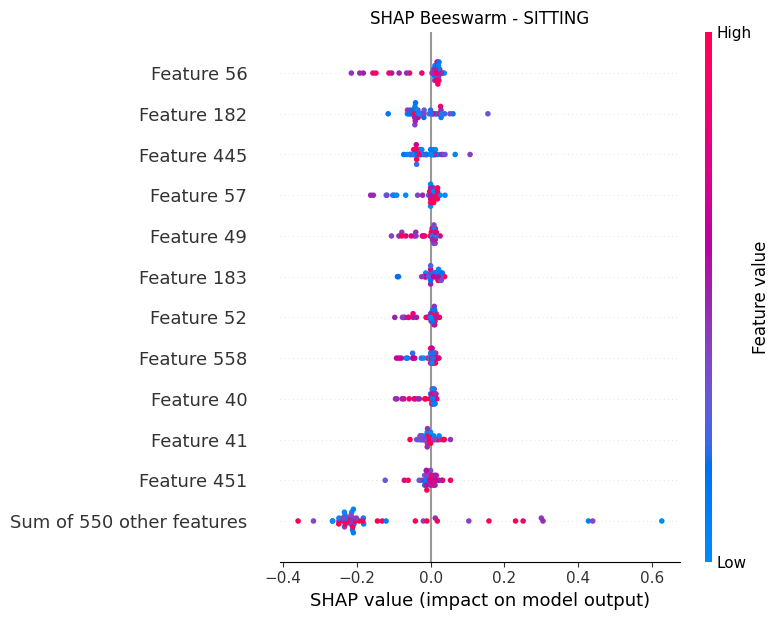

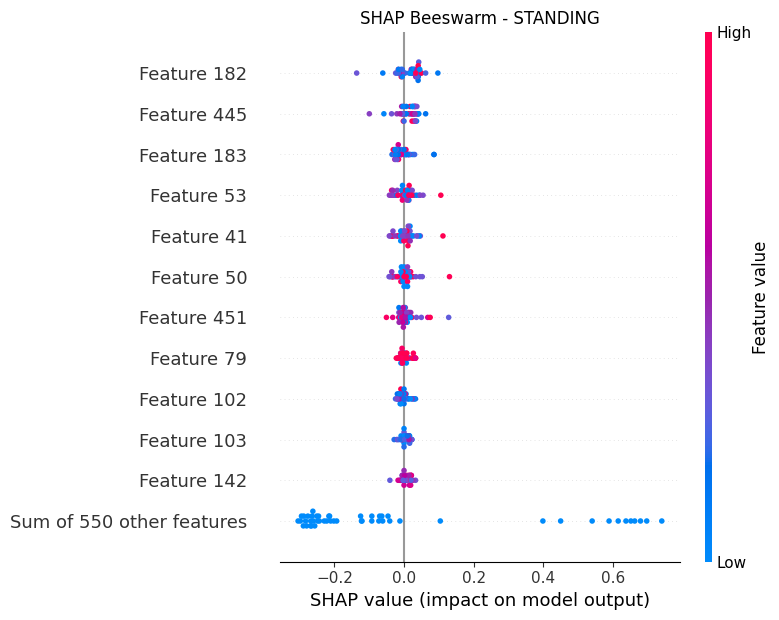

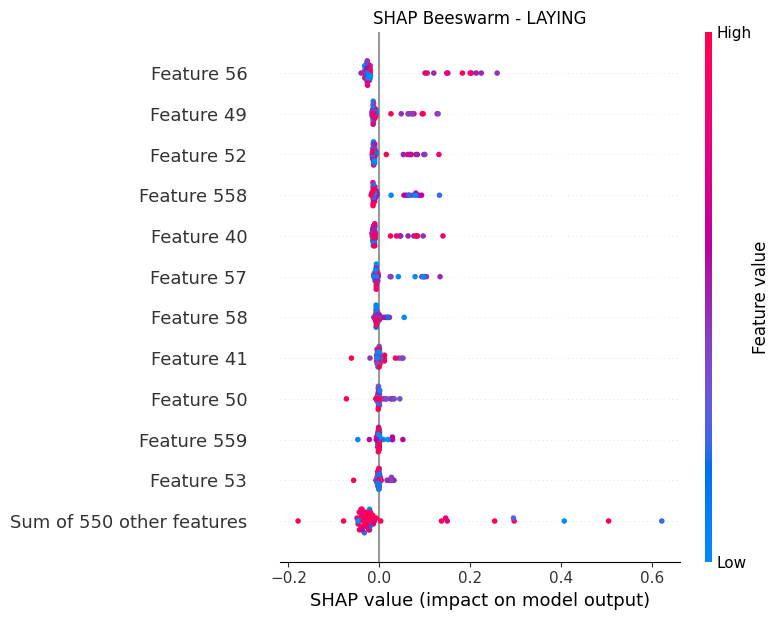

In [ ]:
X_test_sample = X_test[:50]
feature_names = [f"Feature {i}" for i in range(X_test_sample.shape[1])]

for i in range(6):
    explanation = shap.Explanation(
        values=shap_values[:, :, i],
        base_values=explainer.expected_value[i],
        data=X_test_sample,
        feature_names=feature_names
    )

    plt.figure()
    shap.plots.beeswarm(
        explanation,
        max_display=12,
        show=False
    )
    plt.title(f"SHAP Beeswarm - {activity_labels[i+1]}")
    plt.tight_layout()
    plt.show()

_Tip for HAR_: there are duplicating features. You may describe their behaviour as part of conclusion.

In [ ]:
# fmt: off
duplicating_columns = (
    205, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 244, 257, 507, 520, 533, 546,
)
# fmt: on

duplicating_mask = np.isin(range(n_features), duplicating_columns)

In [ ]:
if isinstance(shap_values, list):
    shap_array = np.stack(shap_values)
else:
    shap_array = shap_values
dup_shap = np.array([shap_array[:, i, :] for i in duplicating_columns])
mean_importance = np.mean(np.abs(dup_shap), axis=(1, 2))

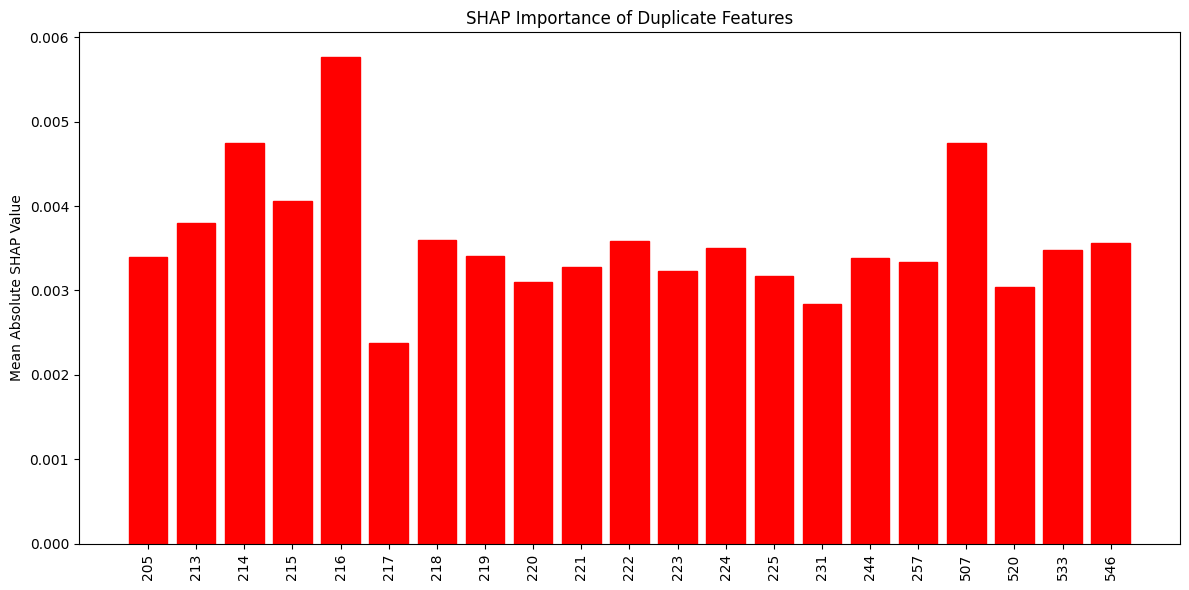

In [ ]:
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(duplicating_columns)), mean_importance)
plt.xticks(range(len(duplicating_columns)), duplicating_columns, rotation=90)
plt.title("SHAP Importance of Duplicate Features")
plt.ylabel("Mean Absolute SHAP Value")

std_importance = np.std(np.abs(dup_shap), axis=(1, 2))
problematic = std_importance > (0.3 * mean_importance)
for bar, is_problem in zip(bars, problematic):
    if is_problem:
        bar.set_color('red')

plt.tight_layout()
plt.show()

### Conclusion

Your thoughts about the plots and model behaviour (not limited to duplicating features):

After seeing the plots these are conclusions:

Most influential features are
1. Feature 56, 182 , 445 .
2. The SHAP analysis reveals that gravity related features min/max/angle and peak acceleration/jerk values are most critical for activity recognition, particularly for distinguishing postural changes

Duplicate features showed instability by high SHAP variability


Beeswarm plot showed  physically meaningful decision making for example high Z axis acceleration for upstairs walking.



